In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
np.random.seed(1)

T = 40
L = 200 # length of time-series
N = 600 # dataset size

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin((x.T / ((np.random.rand(N)**2)*T + 1)).T).astype('float64')

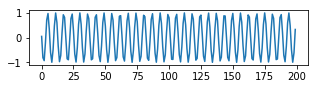

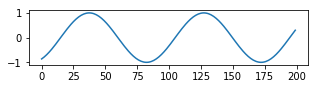

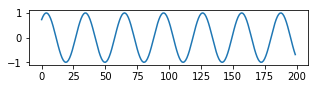

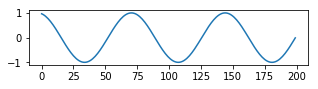

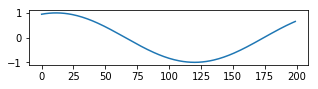

In [5]:
# here we plot some generated time-series
for i in range(5):
    plt.figure(figsize=(5, 1))
    plt.plot(data[i])

In [6]:
device = torch.device("cpu")

In [7]:
batch_size = 64
log_interval = N/600

In [8]:
data_tensor = torch.stack([torch.Tensor(x) for x in data])

In [9]:
data_tensor.shape

torch.Size([600, 200])

In [10]:
ts_dataset_train = torch.utils.data.TensorDataset(data_tensor[:int(N*5/6)])
ts_dataset_test = torch.utils.data.TensorDataset(data_tensor[int(N*5/6):])

In [11]:
train_loader = torch.utils.data.DataLoader(ts_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ts_dataset_test, batch_size=batch_size, shuffle=True)

In [12]:
# VAE model

class VAE(nn.Module):
    def __init__(self, K=12, P=5, mp=3, hidden_lsz=2, channels=10, lstm_sz=10):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=channels, kernel_size=K, padding=P)
        self.mp1 = nn.MaxPool1d(kernel_size=mp, stride=mp, return_indices=True)
        conv_sz = self.conv1.out_channels * ((L + 1 - (K - 2*P)) // mp)
        self.fc21 = nn.Linear(conv_sz, hidden_lsz)
        self.fc22 = nn.Linear(conv_sz, hidden_lsz)
        self.fc3 = nn.Linear(hidden_lsz, conv_sz)
        self.ump4 = nn.MaxUnpool1d(kernel_size=mp, stride=mp)
        self.deconv4 = nn.ConvTranspose1d(in_channels=channels, out_channels=1, kernel_size=K, padding=P)
        self.polish = nn.LSTM(1, lstm_sz, num_layers=1)
        self.fc4 = nn.Linear(lstm_sz, 1)

    def encode(self, x):
        h1, self.mp1_inds = self.mp1(F.relu(self.conv1(x.unsqueeze(1))))
        h1 = h1.view(h1.shape[0], -1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.ump4(F.relu(self.fc3(z).unsqueeze(1).view(z.shape[0], self.deconv4.in_channels, -1)),
                       self.mp1_inds)
        h4 = F.relu(self.deconv4(h3))
        h4 = h4.transpose(1, 0).transpose(2, 0)
        h5, _ = self.polish(h4)
        h5 = F.relu(h5)
        return self.fc4(h5).transpose(1, 0).squeeze()

    def forward(self, x, variational_sample=1):
        mu, logvar = self.encode(x.view(-1, L))
        for i in range(variational_sample):
            z = self.reparameterize(mu, logvar)
            recon_x = self.decode(z)
            if i == 0:
                reconstruction = torch.zeros_like(recon_x)
            reconstruction += recon_x
        reconstruction /= variational_sample
        return reconstruction, mu, logvar


In [13]:
def loss_component_KLD(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return KLD

In [14]:
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x.view(-1, x.shape[1]))

    return MSE + loss_component_KLD(mu, logvar)

In [15]:
def train(epoch, max_batches=2):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data[:, :recon_batch.shape[1]], mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if batch_idx / log_interval >= max_batches:
                break
    
    train_loss /= ((batch_idx + 1)*batch_size)
    return train_loss

In [16]:
def save_ts_image_overlap(ts_tensor_1, ts_tensor_2, file_path, nrow=1, h=1, w=3, off_axis=False):
    ncol = int(np.ceil(len(ts_tensor_1)/float(nrow)))
    plt.figure(figsize=(w*nrow, h*ncol))
    for i in range(len(ts_tensor_1)):
        plt.subplot(ncol, nrow, i + 1)
        plt.plot(ts_tensor_1[i].data.numpy())
        plt.plot(ts_tensor_2[i].data.numpy())
        if off_axis:
            plt.xticks([])
            plt.yticks([])
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches='tight', dpi=100)
    plt.close()

In [17]:
def test(epoch, recon_samples=10):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data[0].to(device)
            
            for r in range(recon_samples):
                recon_batch_part, mu, logvar = model(data)
                if r == 0:
                    recon_batch = recon_batch_part
                else:
                    recon_batch += recon_batch_part
            recon_batch /= recon_samples
            
            test_loss += loss_function(recon_batch, data[:, :recon_batch.shape[1]], mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n, :recon_batch.shape[1]],
                                      recon_batch[:n]])
                save_ts_image_overlap(data[:n, :recon_batch.shape[1]], recon_batch[:n],
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [18]:
latent_dim = 5

In [19]:
model = VAE(K=36, P=17, hidden_lsz=latent_dim, channels=10, mp=4, lstm_sz=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print('number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

number of model parameters: 9112


In [20]:
epochs = 200

In [21]:
train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    t = train(epoch, max_batches=30)
    if epoch % 10 == 0:
        train_losses.append(t)
        test_losses.append(test(epoch))

====> Test set loss: 100.6658
====> Test set loss: 98.7445
====> Test set loss: 98.3177
====> Test set loss: 53.7238
====> Test set loss: 33.3709
====> Test set loss: 29.4616
====> Test set loss: 23.6880
====> Test set loss: 20.6529
====> Test set loss: 17.4397
====> Test set loss: 15.9137
====> Test set loss: 13.1190
====> Test set loss: 12.3393
====> Test set loss: 10.9140
====> Test set loss: 10.5779
====> Test set loss: 9.3767
====> Test set loss: 8.7245
====> Test set loss: 8.5526
====> Test set loss: 8.6392
====> Test set loss: 8.1497
====> Test set loss: 7.5951


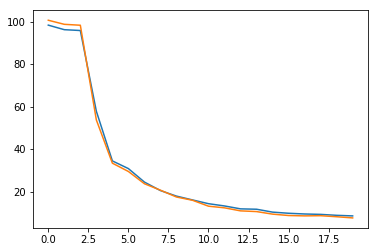

In [22]:
plt.plot(train_losses)
plt.plot(test_losses)